# Exploratory Data Analysis with db_connector

This notebook demonstrates how to perform exploratory data analysis (EDA) before proceeding with data preprocessing tasks using the `db_connector.py` created earlier.

In [1]:
# Import necessary libraries
import pandas as pd
import gc  # Python's garbage collection module
from db_connector import DatabaseConnector
from urllib.parse import quote_plus 
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns

## Database Connection

Establish a connection to the database using the `DatabaseConnector` class.

In [2]:
# Database configuration
config = {
        "host": "localhost",
        "user": "admin", 
        "password": "P@ssw0rd1",  # URL encode the password
        "database": "default_schema"
}

# Initialize DatabaseConnector with SQLAlchemy
db_connector = DatabaseConnector(config, use_sqlalchemy=True)
db_connector.connect()


2024-03-24 20:24:13,151 - INFO - Database connection successful (SQLAlchemy).


## Perform EDA

Use the database connection to query data and perform exploratory data analysis.

In [3]:
import mitosheet
mitosheet.sheet()

ModuleNotFoundError: No module named 'mitosheet'

2024-02-21 12:45:33,655 - INFO - Database connection successful (SQLAlchemy).
C:\Users\user\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Executed query for table: fuelprice
Executed query for table: pricecatcher_combined
Performing EDA on results from: fuelprice
id             0
series_type    0
date           0
ron95          0
ron97          0
diesel         0
start_date     0
end_date       0
dtype: int64
                id series_type        date       ron95       ron97  \
count   681.000000         681         681  681.000000  681.000000   
unique         NaN           2         341         NaN         NaN   
top            NaN       level  2020-10-31         NaN         NaN   
freq           NaN         341           2         NaN         NaN   
mean    341.000000         NaN         NaN    1.011292    1.416153   
min       1.000000         NaN         NaN   -0.380000   -0.360000   
25%     171.000000         NaN         NaN    0.000000    0.000000   
50%     341.000000         NaN         NaN    1.250000    1.550000   
75%     511.000000         NaN         NaN    2.050000    2.620000   
max     681.000000       

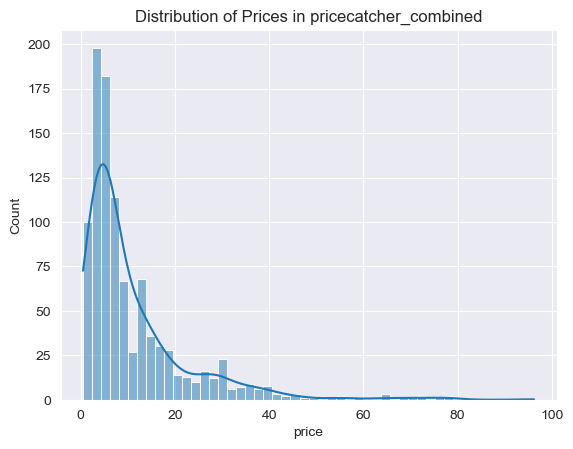

2024-02-21 12:45:33,951 - INFO - Database connection closed.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Assuming the DatabaseConnector class and config are already defined as per your setup

# Define the tables and sample size
tables = {
    "fuelprice": "SELECT * FROM fuelprice LIMIT {sample_size};",
    "pricecatcher_combined": """
        SELECT pc.date, pc.item_code, li.item, li.unit, pc.price, 
               lp.premise, lp.address, lp.premise_type, lp.state, lp.district 
        FROM pricecatcher pc 
        LEFT JOIN lookup_item li ON li.item_code = pc.item_code 
        LEFT JOIN lookup_premise lp ON lp.premise_code = pc.premise_code LIMIT {sample_size};
    """
}

# Set the sample size
sample_size = 1000

# Initialize the DatabaseConnector
db_connector = DatabaseConnector(config, use_sqlalchemy=True)  # Ensure this is set based on your use case
db_connector.connect()

# Dictionary to hold the results of each query
query_results = {}

# Execute each query and store the result in the dictionary
for table_name, query in tables.items():
    formatted_query = query.format(sample_size=sample_size)
    # Adjust the connection object based on the connector used
    connection_obj = db_connector.engine if db_connector.use_sqlalchemy else db_connector.connection
    query_results[table_name] = pd.read_sql(formatted_query, con=connection_obj)
    print(f"Executed query for table: {table_name}")

# Perform EDA on the results
for table_name, data in query_results.items():
    print(f"Performing EDA on results from: {table_name}")
    # Check for missing values
    print(data.isnull().sum())
    
    # Descriptive statistics
    print(data.describe(include='all'))  # 'include=all' to get statistics for all columns
    
    # For visualizations, you can use seaborn or matplotlib
    # For example, if you want to visualize the distribution of prices in the pricecatcher_combined dataset:
    if 'price' in data.columns:
        sns.histplot(data['price'], kde=True)
        plt.title(f'Distribution of Prices in {table_name}')
        plt.show()

# Close the database connection after EDA
db_connector.close_connection()


In [ ]:
import math

# Assuming the DatabaseConnector and necessary imports are already defined

def process_table_in_batches(db_connector, table_name, batch_size):
    # Determine the total number of rows in the table
    total_rows_query = f"SELECT COUNT(*) FROM {table_name}"
    total_rows = pd.read_sql(total_rows_query, db_connector.engine)['COUNT(*)'].iloc[0]
    
    # Calculate the number of batches needed
    num_batches = math.ceil(total_rows / batch_size)
    
    for batch_num in range(num_batches):
        offset = batch_size * batch_num
        batch_query = f"SELECT * FROM {table_name} LIMIT {batch_size} OFFSET {offset}"
        
        # Use Dask or Pandas to process the batch
        ddf = dd.read_sql_table(table_name, uri=db_connector.sqlalchemy_url(), index_col='id', divisions=(offset, offset+batch_size), npartitions=1)  # Adjust as needed
        
        # Perform batch EDA or processing here
        # For example, compute summary statistics for the batch
        print(f"Batch {batch_num + 1}/{num_batches} stats for {table_name}:")
        print(ddf.describe().compute())  # Remember, Dask operations are lazy
        
    print(f"Completed processing for table {table_name}")

# Example usage
db_connector = DatabaseConnector(config, use_sqlalchemy=True)
db_connector.connect()

# Process each table in batches
for table in table_names:
    process_table_in_batches(db_connector, table, sample_size)

db_connector.close_connection()


In [ ]:
import math
import pandas as pd
import dask.dataframe as dd

def process_table_in_batches(db_connector, table_name, batch_size):
    # Determine the total number of rows in the table
    total_rows_query = f"SELECT COUNT(*) FROM {table_name}"
    total_rows = pd.read_sql(total_rows_query, db_connector.engine).iloc[0, 0]
    
    # Calculate the number of batches needed
    num_batches = math.ceil(total_rows / batch_size)
    
    for batch_num in range(num_batches):
        offset = batch_size * batch_num
        # Assuming 'id' is the primary key and indexed
        batch_query = f"SELECT * FROM {table_name} LIMIT {batch_size} OFFSET {offset}"
        
        # Adjust npartitions to better utilize Dask's parallel processing
        npartitions = min(10, num_batches)  # Example adjustment, tweak based on your setup
        ddf = dd.read_sql_table(table_name, uri=db_connector.sqlalchemy_url(), index_col='id', divisions=(offset, offset + batch_size), npartitions=npartitions)
        
        # Perform batch processing
        print(f"Batch {batch_num + 1}/{num_batches} stats for {table_name}:")
        print(ddf.describe().compute())  # Dask operations are lazy
        
    print(f"Completed processing for table {table_name}")


In [10]:
# Define the tables and sample size
table_name = ['fuelprice', 'pricecatcher', 'lookup_item', 'lookup_premise']
sample_size = 10000

# Function to sample data from a specified table
def sample_data(db_connector, table_name, sample_size):
    query = f"SELECT * FROM {table_name} ORDER BY RAND() LIMIT {sample_size}"
    return pd.read_sql(query, db_connector.engine)

# Assuming the DatabaseConnector class and config are already defined as per your setup
db_connector = DatabaseConnector(config, use_sqlalchemy=True)
db_connector.connect()

# Dictionary to hold sampled data from each table
sampled_data = {}

# Iterate over each table and sample the data
for table in table_name:
    sampled_data[table] = sample_data(db_connector, table, sample_size)
    print(f"Sampled {sample_size} rows from table {table}")

# Now you have a dictionary with sampled data for each table
# You can perform EDA on each one like so:
for table, data in sampled_data.items():
    print(f"Performing EDA on table: {table}")
    # Check for missing values
    print(f"Check for missing values on table: {table}")
    print(data.isnull().sum())
    
    # Descriptive statistics
    print(f"Check for Descriptive statistics on table: {table}")
    print(data.describe())
    
# Close the database connection after EDA
db_connector.close_connection()

2024-02-15 12:21:04,872 - INFO - Database connection successful (SQLAlchemy).


Sampled 10000 rows from table fuelprice


2024-02-15 12:22:30,452 - INFO - Database connection closed.


Sampled 10000 rows from table pricecatcher
Sampled 10000 rows from table lookup_item
Sampled 10000 rows from table lookup_premise
Performing EDA on table: fuelprice
Check for missing values on table: fuelprice
id             0
series_type    0
date           0
ron95          0
ron97          0
diesel         0
start_date     0
end_date       0
dtype: int64
Check for Descriptive statistics on table: fuelprice
               id       ron95       ron97      diesel  \
count  681.000000  681.000000  681.000000  681.000000   
mean   341.000000    1.011292    1.416153    1.049677   
min      1.000000   -0.380000   -0.360000   -0.170000   
25%    171.000000    0.000000    0.000000    0.000000   
50%    341.000000    1.250000    1.550000    1.400000   
75%    511.000000    2.050000    2.620000    2.150000   
max    681.000000    2.380000    4.840000    2.340000   
std    196.732051    1.020154    1.495230    1.055169   

                          start_date                       end_date  
coun

In [8]:
# Close the database connection after EDA
db_connector.close_connection()

2024-02-15 12:12:53,644 - INFO - Database connection closed.


In [ ]:
db_connector = DatabaseConnector(config, use_sqlalchemy=True)
db_connector.connect()

# Query to fetch the data
query = "SELECT * FROM fuelprice"
fuelprice = pd.read_sql(query, db_connector.engine)

# Close the database connection after EDA
db_connector.close_connection()

In [8]:
# Example query to fetch data
query = "SELECT * FROM pricecatcher LIMIT 50"
data = pd.read_sql_query(query, db_connector.connection)

# Display the first few rows of the dataframe
data.head()


,date,premise_code,item_code,price
0,2022-01-01,2,1,9.1
1,2022-01-01,2,9,36.0
2,2022-01-01,2,14,24.0
3,2022-01-01,2,16,4.3
4,2022-01-01,2,18,4.5


## Exploratory Data Analytics

Creation of fetch_data Function for Multiprocessing

In [ ]:
def fetch_data(args):
    table, query = args
    # Assuming you have a way to establish a connection inside this function. 
    # This might involve using a database URI or connection string that's globally available or passed as part of the query.
    db_connector = DatabaseConnector(config, use_sqlalchemy=True)  # Assuming config is defined globally or passed correctly
    db_connector.connect()
    data = pd.read_sql_query(query, db_connector.connection)
    db_connector.close_connection()
    return table, data


In [4]:
import pandas as pd
import gc  # Python's garbage collection module

def fetch_data(args, batch_size, offset):
    table, base_query = args
    # Initialize db_connector outside the try block to access it in finally
    db_connector = None
    try:
        # Assuming DatabaseConnector and config are defined and handle connection setup using SQLAlchemy or similar
        db_connector = DatabaseConnector(config, use_sqlalchemy=True)
        db_connector.connect()
        
        # Modify the query to include LIMIT and OFFSET for batch processing
        batch_query = f"{base_query} LIMIT {batch_size} OFFSET {offset}"
        
        # Execute the batch query and fetch data into a pandas DataFrame
        data = pd.read_sql_query(batch_query, db_connector.connection)
        
        # Optionally optimize DataFrame memory usage here
        
        return table, data
    finally:
        # Ensure the database connection is closed even if an error occurs
        if db_connector:
            db_connector.close_connection()
        gc.collect()  # Optional: Trigger garbage collection after each batch

# Example usage
if __name__ == "__main__":
    queries = {
        "fuelprice": "SELECT * FROM fuelprice",
        "pricecatcher": "SELECT pc.date, pc.item_code,li.item,li.unit,pc.price, lp.premise, lp.address, lp.premise_type, lp.state, lp.district FROM pricecatcher pc left join lookup_item li on li.item_code = pc.item_code left join lookup_premise lp on lp.premise_code = pc.premise_code"
    }
    
    batch_size = 1500000  # Adjusted batch size for memory efficiency
    
    all_data = {}  # Dictionary to store combined data frames of all batches
    
    for table, query in queries.items():
        total_records_fetched = 0
        offset = 0
        table_data = []  # List to store data frames of all batches for this table
        
        while True:
            _, batch_data = fetch_data((table, query), batch_size, offset)
            if batch_data.empty:
                break  # No more data to fetch
            table_data.append(batch_data)
            total_records_fetched += len(batch_data)
            offset += batch_size
            print(f"{table}: Batch processed. Total records fetched: {total_records_fetched}")
            
        # Combine all DataFrames for this table, if needed
        if table_data:  # Check if there's any data to avoid errors
            all_data[table] = pd.concat(table_data, ignore_index=True)


2024-02-13 18:04:59,131 - INFO - Database connection successful (SQLAlchemy).
2024-02-13 18:04:59,140 - INFO - Database connection closed.
2024-02-13 18:04:59,209 - INFO - Database connection successful (SQLAlchemy).
2024-02-13 18:04:59,213 - INFO - Database connection closed.
2024-02-13 18:04:59,273 - INFO - Database connection successful (SQLAlchemy).


fuelprice: Batch processed. Total records fetched: 681


2024-02-13 18:05:18,117 - INFO - Database connection closed.
2024-02-13 18:05:18,166 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 1500000


2024-02-13 18:05:35,998 - INFO - Database connection closed.
2024-02-13 18:05:36,051 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 3000000


2024-02-13 18:05:56,617 - INFO - Database connection closed.
2024-02-13 18:05:56,660 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 4500000


2024-02-13 18:06:36,224 - INFO - Database connection closed.
2024-02-13 18:06:36,290 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 6000000


2024-02-13 18:07:12,558 - INFO - Database connection closed.
2024-02-13 18:07:12,621 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 7500000


2024-02-13 18:07:45,368 - INFO - Database connection closed.
2024-02-13 18:07:45,430 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 9000000


2024-02-13 18:08:36,045 - INFO - Database connection closed.
2024-02-13 18:08:36,092 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 10500000


2024-02-13 18:09:29,714 - INFO - Database connection closed.
2024-02-13 18:09:29,777 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 12000000


2024-02-13 18:10:23,198 - INFO - Database connection closed.
2024-02-13 18:10:23,264 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 13500000


2024-02-13 18:11:08,090 - INFO - Database connection closed.
2024-02-13 18:11:08,131 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 15000000


2024-02-13 18:12:11,735 - INFO - Database connection closed.
2024-02-13 18:12:11,798 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 16500000


2024-02-13 18:13:19,842 - INFO - Database connection closed.
2024-02-13 18:13:19,889 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 18000000


2024-02-13 18:14:31,985 - INFO - Database connection closed.
2024-02-13 18:14:32,032 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 19500000


2024-02-13 18:15:44,894 - INFO - Database connection closed.
2024-02-13 18:15:44,959 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 21000000


2024-02-13 18:17:04,195 - INFO - Database connection closed.
2024-02-13 18:17:04,244 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 22500000


2024-02-13 18:18:14,081 - INFO - Database connection closed.
2024-02-13 18:18:14,129 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 24000000


2024-02-13 18:19:25,177 - INFO - Database connection closed.
2024-02-13 18:19:25,223 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 25500000


2024-02-13 18:20:45,352 - INFO - Database connection closed.
2024-02-13 18:20:45,420 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 27000000


2024-02-13 18:22:00,594 - INFO - Database connection closed.
2024-02-13 18:22:00,657 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 28500000


2024-02-13 18:23:22,786 - INFO - Database connection closed.
2024-02-13 18:23:22,830 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 30000000


2024-02-13 18:25:02,920 - INFO - Database connection closed.
2024-02-13 18:25:02,983 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 31500000


2024-02-13 18:26:32,178 - INFO - Database connection closed.
2024-02-13 18:26:32,232 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 33000000


2024-02-13 18:28:02,822 - INFO - Database connection closed.
2024-02-13 18:28:02,884 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 34500000


2024-02-13 18:29:37,893 - INFO - Database connection closed.
2024-02-13 18:29:37,947 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 36000000


2024-02-13 18:31:18,768 - INFO - Database connection closed.
2024-02-13 18:31:18,845 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 37500000


2024-02-13 18:33:02,999 - INFO - Database connection closed.
2024-02-13 18:33:03,062 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 39000000


2024-02-13 18:34:46,464 - INFO - Database connection closed.
2024-02-13 18:34:46,528 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 40500000


2024-02-13 18:36:34,995 - INFO - Database connection closed.
2024-02-13 18:36:35,042 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 42000000


2024-02-13 18:38:29,130 - INFO - Database connection closed.
2024-02-13 18:38:29,200 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 43500000


2024-02-13 18:40:25,044 - INFO - Database connection closed.
2024-02-13 18:40:25,095 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 45000000


2024-02-13 18:42:25,787 - INFO - Database connection closed.
2024-02-13 18:42:25,860 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 46500000


2024-02-13 18:44:31,624 - INFO - Database connection closed.
2024-02-13 18:44:31,671 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 48000000


2024-02-13 18:46:40,809 - INFO - Database connection closed.
2024-02-13 18:46:40,855 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 49500000


2024-02-13 18:48:46,146 - INFO - Database connection closed.
2024-02-13 18:48:46,191 - INFO - Database connection successful (SQLAlchemy).


pricecatcher: Batch processed. Total records fetched: 50666976


2024-02-13 18:50:41,362 - INFO - Database connection closed.


In [7]:
table_data.head()

AttributeError: 'list' object has no attribute 'head'

In [ ]:
queries = {
    "fuelprice": "SELECT * FROM fuelprice",
    "pricecatcher": "SELECT  pc.date, pc.item_code,li.item,li.unit,pc.price, lp.premise, lp.address, lp.premise_type, lp.state, lp.district FROM pricecatcher pc left join lookup_item li on li.item_code = pc.item_code left join lookup_premise lp on lp.premise_code = pc.premise_code limit 1000;"
}

# Prepare the arguments for starmap
args = [(table, query) for table, query in queries.items()]

# Execute queries in parallel
with Pool(processes=len(queries)) as pool:
    results = pool.map(fetch_data, args)

# Convert list of tuples back into a dictionary {table_name: dataframe}
dataframes = {table: df for table, df in results}


## Data Preprocessing

After performing EDA, proceed with data preprocessing tasks as needed.

In [ ]:
# Define your SQL queries
# Customized queries for your specific tables
queries = {
    "fuelprice": "SELECT * FROM fuelprice",
    "lookup_item": "SELECT * FROM lookup_item",
    "lookup_premise": "SELECT * FROM lookup_premise",
    "pricecatcher": "SELECT * FROM pricecatcher",
    # Add as many queries as needed for different tables test
}

# Function to execute a query and fetch data
def fetch_data(query, connector):
    connector.connect()  # Ensure the connection is open
    data = pd.read_sql_query(query, connector.connection)
    connector.close_connection()  # Close the connection after fetching data
    return data

# Execute queries and store results in a dictionary
dataframes = {table: fetch_data(query, db_connector) for table, query in queries.items()}

# Example of how to access and display the first 5 rows of the fetched data for each table in a tidy format
for table, df in dataframes.items():
    display(f"Data from {table}:")  # This will print the table name in a neat format
    display(df.head())  # This will display the first 5 rows of the DataFrame in a neat, table-like format

    print("\n")  # Just to add a space between tables for better readability


In [ ]:
for table_name, df in dataframes.items():
    print(f"--- {table_name.upper()} ---")
    print("Structure:\n", df.info())
    print("Summary Statistics:\n", df.describe())
    print("First Few Rows:\n", df.head(), "\n\n")


In [ ]:
# Further processing, integration, and exploratory data analysis can proceed from here
# For example, you can use the dataframes dictionary to access the data for each table and perform operations such as joining tables, filtering, aggregating, etc.  
# You can also use visualization libraries such as Matplotlib, Seaborn, or Plotly to create visualizations for the data.

# Example: Joining two tables
# merged_data = pd.merge(dataframes["fuelprice"], dataframes["pricecatcher"], on="id", how="inner")

## Close Database Connection

It's important to close the database connection after the operations are complete to prevent memory leaks.

In [8]:
# Close the database connection
db_connector.close_connection()


2024-02-20 13:09:32,211 - INFO - Database connection closed.
